In [70]:
import torch
import torchvision
import pandas as pd
from torchvision.transforms import transforms
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [71]:
train = pd.read_csv('input/digit_kaggle/train.csv')

In [72]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
target_np = train.label.values
featues_np = train.loc[:, train.columns != 'label'].values/255

In [74]:
# features(train, test), targets(train, test)
x_train, x_test, y_train, y_test = train_test_split(featues_np, target_np, test_size=0.2, random_state=42)

In [75]:
# features
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)

# targets
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

In [76]:
# batch size, epochs, iterations
batch_size = 100
num_iteration = 1000
epochs = num_iteration / len(x_train / batch_size)
epochs = int(epochs)

In [77]:
# train and test set for pytorch
train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)

In [78]:
# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

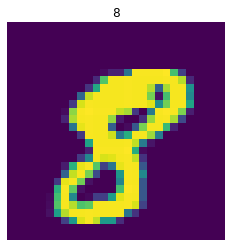

In [79]:
plt.imshow(featues_np[10].reshape(28, 28))
plt.axis("off")
plt.title(str(target_np[10]))
plt.show()

In [91]:
# CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # 1st conv layer
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu_1 = nn.ReLU()
        self.maxpool_1 = nn.MaxPool2d(kernel_size=2)

        # 2nd conv layer
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu_2 = nn.ReLU()
        self.maxpool_2 = nn.MaxPool2d(kernel_size=2)

        # 3rd conv layer
        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0)
        self.relu_3 = nn.ReLU()
        self.maxpool_3 = nn.MaxPool2d(kernel_size=2)

        # FC layer
        self.fc_1 = nn.Linear(64 * 4 * 4, 10)

    def forward(self, x):
        out = self.conv_1(x)
        out = self.relu_1(out)
        out = self.maxpool_1(out)
        out = self.conv_2(out)
        out = self.relu_2(out)
        out = self.maxpool_2(out)
        out = self.conv_3(out)
        out = self.relu_3(out)
        out = self.maxpool_3(out)

        out = out.view(out.size(0), -1) # flatten
        out = self.fc_1(out)
        return out

        

# instantiate the model, loss, and optimizer
model = CNNModel()
loss = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [92]:
# CNN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = loss(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        count += 1
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                
                test = Variable(images.view(100,1,28,28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data[0], accuracy))